In [1]:
# !pip install python-graphblas[default]

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
import random
from graphblas.io import mmread
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring

# **Bellman Ford с одной стартовой вершиной**

Используя python-graphblas реализовать функцию поиска кратчайших путей в ориентированном графе из заданной вершины (Bellman–Ford).
- Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и номер стартовой вершины. <br><br>
- Функция возвращает массив, где для каждой вершины указано расстояние до неё от указанной стартовой вершины. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [3]:
# ошибка присутсвия цикла орицательного веса

class NegativeWeightError(Exception):
    print("Присутсвует цикл отрицательного веса")

Присутсвует цикл отрицательного веса


In [37]:
def Bellman_Ford(A, vertex):
    
    m = A.nrows
    
    # создаем вектор
    v = Vector(A.dtype, m)
    # инициализируем начальную вершину с нулевым расстоянием
    v[vertex] << 0
    
    # реализация алгоритма обхода графа
    w = v.dup()
    for i in range(m - 1):
        w_old = w.dup()
        w(binary.min) << w.vxm(A, semiring.min_plus)
        if w.isequal(w_old):
            break
            
    # проверка на наличие циклов отрицательного веса
    w_old = w.dup()
    w(binary.min) << w.vxm(A, semiring.min_plus)
    
    # при наличие выводим ошибку с сообщением
    if not w.isequal(w_old):
        raise NegativeWeightError("Би КАРЕФУЛ!!! Цикл отрицательного веса")
        
    # Вывод ответа
    final = []
    for i in range(m):
        if w[i].value is None:
            final.append(float('inf')) # если вершина недостижима, то значение 'inf'
        else:
            final.append(w[i].value)   # формируем массив с расстояниями от стартовой вершины до остальных
    return final

# **Bellman Ford с несколькими стартовыми вершинами**

Используя python-graphblas реализовать функцию поиска кратчайших путей в ориентированном графе из нескольких заданных вершин, модифицировав предыдущий алгоритм.
- Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин. <br><br>
- Функция возвращает массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

In [5]:
def Bellman_Ford2(A, massiv):
    
    # кол-во вершин в графе
    n = A.ncols
    # кол-во стартовых вершин
    m = massiv.size
    
    # создание матрицы
    # инициализация начальных вершин с нулевым расстояниеми
    v = Matrix(dtypes.INT32, m, n)
    for i in range(m):
        v[i, massiv[i]] << 0
        
    # реализация алгоритма обхода графа
    w = v.dup()
    for i in range(n - 1):
        w_old = w.dup()
        for i in range(m):
            w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)
        if w.isequal(w_old):
            break
    
        
    #проверка на цикл отрицательного веса
    w_old = w.dup()
    for i in range(m):
        w[i,:](binary.min) << w[i,:].vxm(A, semiring.min_plus)
    if not w.isequal(w_old):
        raise NegativeWeightError("Би КАРЕФУЛ!!! Цикл отрицательного веса")
        
   
    # все ок -> вывод ответа:
    # расстояния помещаем в массив пар final
    final = {}
    for i in range(m):
        values = []
        for j in range(n):
            if w[i, j].value is None: 
                values.append(float('inf'))  # если вершина недостижима, то значение 'inf'
            else:
                values.append(w[i, j].value) # формируем массив с расстояниями от стартовой вершины до остальных
        final[massiv[i]] = (values)
    return final

In [6]:
def FloydWarshall(matrix):
    
    dist = matrix.dup()
    n = matrix.nrows
    temp_dist = matrix.dup()
    
    for k in range(n):
        
        # create matrices for easier multiplication
        dist_col = Matrix(dtypes.INT32, n, n)
        dist_row = Matrix(dtypes.INT32, n, n)
        dist_col[:, k] = dist[:, k].dup()
        dist_row[k, :] = dist[k, :].dup()
        temp_dist << dist_col.mxm(dist_row, semiring.min_plus)
        
        # treat None values as infinitely large
        dist << dist.ewise_add(temp_dist, op="min")
        
    # check for negative weight cycles
    dist1 = dist.dup()
    temp_dist1 = temp_dist.dup()
    dist_col1 = Matrix(dtypes.INT32, n, n)
    dist_row1 = Matrix(dtypes.INT32, n, n)
    dist_col1[:, k] = dist1[:, k].dup()
    dist_row1[k, :] = dist1[k, :].dup()
    temp_dist1 << dist_col1.mxm(dist_row1, semiring.min_plus)
    dist1 << dist1.ewise_add(temp_dist1, op="min")
    
    if not dist1.isequal(dist):
        raise NegativeWeightError("БИКАРЕФУЛ!!! в графе есть цикл отрицательного веса")
    
    # format output
    result = {}
    for i in range(n):
        val_list = []
        for j in range(n):
            if i == j:
                val_list.append(0)
            elif dist[i, j].value is None:
                val_list.append(float('inf'))
            else:
                val_list.append(dist[i, j].value)
        result[i] = np.array(val_list)
    return result


In [7]:
def TransitiveClosure(m):
    
    rows = m.nrows
    I = Matrix(dtypes.INT32, rows, rows)
    
    for i in range(rows):
        I[i, i] = 1
    D = I.dup()
    
    for i in range(rows):
        D1 = D.dup()
        D = D.mxm(m, semiring.min_plus).ewise_add(I, op="min")
        if D1.isequal(D):
            break
    
    D2 = D.dup()
    D2 = D2.mxm(m, semiring.min_plus).ewise_add(I, op="min")
    
    if not D2.isequal(D):
        raise NegativeWeightError("БИКАРЕФУЛ!!! в графе есть цикл отрицательного веса")

    output = {}
    
    for i in range(rows):
        ar_val = []
        for j in range(rows):
            if D[i, j].value is None:
                ar_val.append(float('inf'))
            elif i == j:
                ar_val.append(0)
            else:
                ar_val.append(D[i, j].value - 1)
        output[i] = np.array(ar_val)
    return output

##  Добавить необходимые тесты.

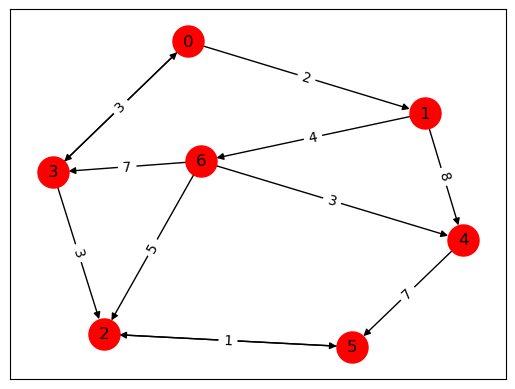

In [8]:
import numpy as np

data = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
    [3, 2, 3, 1, 5, 3, 7, 8, 3, 1, 7, 4],
]

rows, cols, weights = data

m = Matrix.from_coo(rows, cols, weights)

gb.viz.draw(m)

### Беллман-Форд:
При обходе из вершины 1: <br>до 6 прямой путь кратчайший - 4; <br> до 4 вершины из вариантов 1-6-4 и 1-4
короче вариант 1-6-4, он равен 7; <br> до нулевой вершины путь 1-6-3-0 длиной 14; <br> до вершины 2
путь 1-6-2 длиной 9; <br> до вершины 3 путь 1-6-3 длиной 11, <br>до вершины 5 короче будет путь 1-6-2-5 длиной 10.

In [9]:
print('BellmanFord:', Bellman_Ford(m, 1), sep='\n\n')

BellmanFord:

[14, 0, 9, 11, 7, 10, 4]


При обходе из вершины 2 <br> достижима только вершина 5, путь длиной 1. <br> Остальные вершины недостижимы.

In [10]:
print('BellmanFord:', Bellman_Ford(m, 2), sep='\n\n')

BellmanFord:

[inf, inf, 0, inf, inf, 1, inf]


При обходе из вершины 3: <br>до 0 и 2 путь кратчайший прямой - длинами 3 и 3 соответственно; <br>до 1 путь через 0
длиной 5; <br>до 6 самый короткий путь - 3-0-1-6 длиной 9; <br>до 4 ближе будет через 6ку, вычисленную ранее - получится
путь длиной 12; <br>до 5ки путь через 2ку - длина 4.

In [11]:
print('BellmanFord:', Bellman_Ford(m, 3), sep='\n\n')

BellmanFord:

[3, 5, 3, 0, 12, 4, 9]


#### В едином виде:

In [12]:
print('BellmanFord:\n', Bellman_Ford(m, 1), Bellman_Ford(m, 2), Bellman_Ford(m, 3),  sep='\n')

BellmanFord:

[14, 0, 9, 11, 7, 10, 4]
[inf, inf, 0, inf, inf, 1, inf]
[3, 5, 3, 0, 12, 4, 9]


In [13]:
print('Bellman_Ford2:\n')
for row in Bellman_Ford2(m, np.array([1,2,3])).items():
    print(row)

Bellman_Ford2:

(1, [14, 0, 9, 11, 7, 10, 4])
(2, [inf, inf, 0, inf, inf, 1, inf])
(3, [3, 5, 3, 0, 12, 4, 9])


In [14]:
print('FloydWarshall:\n')
for row in FloydWarshall(m).items():
    print(row)


FloydWarshall:

(0, array([0, 2, 6, 3, 9, 7, 6]))
(1, array([14,  0,  9, 11,  7, 10,  4]))
(2, array([inf, inf,  0., inf, inf,  1., inf]))
(3, array([ 3,  5,  3,  0, 12,  4,  9]))
(4, array([inf, inf,  8., inf,  0.,  7., inf]))
(5, array([inf, inf,  1., inf, inf,  0., inf]))
(6, array([10, 12,  5,  7,  3,  6,  0]))


In [15]:
print('TransitiveClosure:\n')
for row in TransitiveClosure(m).items():
    print(row)

TransitiveClosure:

(0, array([0, 2, 6, 3, 9, 7, 6]))
(1, array([14,  0,  9, 11,  7, 10,  4]))
(2, array([inf, inf,  0., inf, inf,  1., inf]))
(3, array([ 3,  5,  3,  0, 12,  4,  9]))
(4, array([inf, inf,  8., inf,  0.,  7., inf]))
(5, array([inf, inf,  1., inf, inf,  0., inf]))
(6, array([10, 12,  5,  7,  3,  6,  0]))


#### Для более точной проверки выведем asserts:

In [16]:
# Bellman Ford       and        Bellman Ford Modified
assert (Bellman_Ford2(m, np.array([1,2,3]))[1] == Bellman_Ford(m, 1))
assert (Bellman_Ford2(m, np.array([1,2,3]))[2] == Bellman_Ford(m, 2))
assert (Bellman_Ford2(m, np.array([1,2,3]))[3] == Bellman_Ford(m, 3))

In [17]:
# Bellman Ford       and        Floyd Warshall
assert (FloydWarshall(m)[1] == Bellman_Ford(m, 1)).all()
assert (FloydWarshall(m)[2] == Bellman_Ford(m, 2)).all()
assert (FloydWarshall(m)[3] == Bellman_Ford(m, 3)).all()

In [18]:
# Floyd Warshall    and         Транзитивного Замыкания
assert (FloydWarshall(m)[0] == TransitiveClosure(m)[0]).all()
assert (FloydWarshall(m)[1] == TransitiveClosure(m)[1]).all()
assert (FloydWarshall(m)[2] == TransitiveClosure(m)[2]).all()
assert (FloydWarshall(m)[3] == TransitiveClosure(m)[3]).all()
assert (FloydWarshall(m)[4] == TransitiveClosure(m)[4]).all()
assert (FloydWarshall(m)[5] == TransitiveClosure(m)[5]).all()
assert (FloydWarshall(m)[6] == TransitiveClosure(m)[6]).all()

#### Проверка на возвращение ошибки:

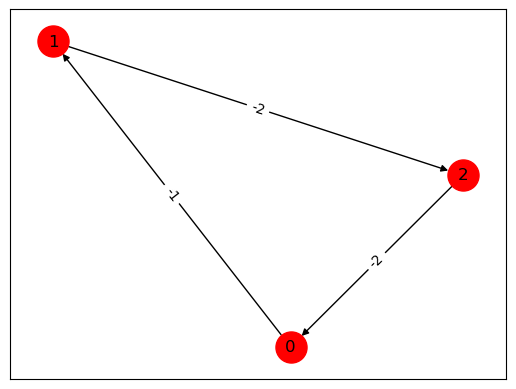

In [19]:
Merr = gb.Matrix.from_coo(
    [0, 1, 2],
    [1, 2, 0],
    [-1,-2,-2],
    nrows=3,
    ncols=3
)
gb.viz.draw(Merr)

In [20]:
Bellman_Ford(Merr, 2)

NegativeWeightError: Би КАРЕФУЛ!!! Цикл отрицательного веса

In [21]:
print(Bellman_Ford2(Merr, np.array([0,2])))

NegativeWeightError: Би КАРЕФУЛ!!! Цикл отрицательного веса

In [22]:
FloydWarshall(Merr)

NegativeWeightError: БИКАРЕФУЛ!!! в графе есть цикл отрицательного веса

In [23]:
TransitiveClosure(Merr)

NegativeWeightError: БИКАРЕФУЛ!!! в графе есть цикл отрицательного веса

# **Дополнительно**

Провести экспериментальное исследование полученных реализаций на некоторых больших графах в формате Matrix Market с сайта SuiteSparse Matrix Collection и на случайных сгенерированных. При этом описать зависимость времени работы всех полученных реализаций от размеров графа, его степени разреженности, количестве стартовых вершин. В частности выяснить, начиная с какой доли вершин в графе целесообразнее использовать алгоритм поиска кратчайших путей для всех пар вершин вместо того, чтобы решать задачу поиска кратчайших путей из нескольких стартовых (модифицированный Bellman-Ford).

In [24]:
graph_names = ['can_838.mtx', 'can_1054.mtx', 'dwt_992.mtx'] # названия графов

In [29]:
# создаем функцию реализации для алгоритмов с подсчетом времени выполнения
def alg_time(M, num):
    print('Bellman_Ford:')
    %timeit (Bellman_Ford(M, n) for n in num)

def alg_time2(M, num):
    print('Bellman_Ford2:')
    %timeit Bellman_Ford2(M, num)
    
def alg_time3(M):
    print('Floyd Warshall:')
    %timeit FloydWarshall(M)

def alg_time4(M):
    print('Транзитивного Замыкания:')
    %timeit TransitiveClosure(M)

In [26]:
# функция генерации массива стартовых вершин
# n - количество вершин в графе
# p - доля генерируемых стартовых вершин
def vertex_generate(n, p):
    population = range(n)
    vertex_array = random.sample(population, round(n * p))
    return np.array(vertex_array)

In [28]:
# Сравнение

gen_vertex = [0.01, 0.05, 0.1, 0.5] # доля генерируемых вершин
for graph_name in graph_names:
    graph = mmread(f'matrixs/{graph_name}')
    print('Количество вершин:', graph.nrows, 'Количество ребер:', graph.nvals)
    for p in gen_vertex:
        vertex = vertex_generate(graph.nrows, p)
        print('Доля стартовых вершин:', p)
        print(alg_time(graph, vertex))
        print(alg_time2(graph, vertex))

Количество вершин: 838 Количество ребер: 10010
Доля стартовых вершин: 0.01
Bellman_Ford:
798 ns ± 71.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
None
Bellman_Ford2:
1.43 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Доля стартовых вершин: 0.05
Bellman_Ford:
898 ns ± 149 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
None
Bellman_Ford2:
7 s ± 291 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Доля стартовых вершин: 0.1
Bellman_Ford:
1.3 µs ± 696 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
None
Bellman_Ford2:
14.3 s ± 783 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Доля стартовых вершин: 0.5
Bellman_Ford:
825 ns ± 62.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
None
Bellman_Ford2:
1min 14s ± 2.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 1054 Количество ребер: 12196
Доля стартовых вершин: 0.01
Bellman_Ford:
1.24 µs ± 400 ns per loop

In [63]:
# Сравнение

vertex = [[1, 5], [10, 5, 85], [22, 53, 4, 51], ]
for graph_name in graph_names:
    graph = mmread(f'matrixs/{graph_name}')
    print('Количество вершин:', graph.nrows, 'Количество ребер:', graph.nvals)
    for num in vertex:
        print('Количество стартовых вершин:', len(num))
        print(alg_time2(graph, num))

Количество вершин: 838 Количество ребер: 10010
Количество стартовых вершин: 2
Bellman_Ford2:
197 ms ± 7.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 3
Bellman_Ford2:
401 ms ± 61.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 4
Bellman_Ford2:
446 ms ± 38.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 1054 Количество ребер: 12196
Количество стартовых вершин: 2
Bellman_Ford2:
279 ms ± 33.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 3
Bellman_Ford2:
416 ms ± 36.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 4
Bellman_Ford2:
618 ms ± 137 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 992 Количество ребер: 16744
Количество стартовых вершин: 2
Bellman_Ford2:
224 ms ± 3.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вер

### Тестирование на случайно сгенерированных графах

In [31]:
# n_rows  -  количество вершин графа
# density -  условно, насколько матрица смежности разряженная

def graph_generator(n_rows, density):
    
    A = gb.Matrix(int, n_rows, n_rows) # пустая матрица
    
    # ограничение на количество итераций
    while density > 0:
        
        # генерация рандомных чисел для матрицы смежности в интервале от 0 до количества ребер -1
        i = random.randint(0, n_rows - 1)
        j = random.randint(0, n_rows - 1)
        
        # проверка, что для данной ячеки еще не генерировались значения
        if A.get(i,j) is None and i != j:
            
            # заполнение матрицы смежности - записываем '1' в ячейку 
            # с только что сгенерированными числами и в смежную ей ячейку
            weight = random.randint(0, 10)
            A[i,j] = weight
            A[j,i] = weight
            density = density - 1
    return A

In [33]:
# 10 / доля 0.1, 0.3, 0.5, 0.75, 1
rows = 10
density = [45, 33, 22, 11]
gen_vertex = [0.1, 0.3, 0.5, 0.75, 1] # доля генерируемых вершин
        
for den in density:
    graph = graph_generator(rows, den)
    print('Количество вершин:', graph.nrows, 'Количество ребер:', graph.nvals)
    print(alg_time3(graph))
    print(alg_time4(graph))
    for p in gen_vertex:
        vertex = vertex_generate(graph.nrows, p)
        print('Количество стартовых вершин:', round(graph.nrows * p))
        print(alg_time(graph, vertex))
        print(alg_time2(graph, vertex))

Количество вершин: 10 Количество ребер: 90
Floyd Warshall:
34.2 ms ± 2.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Транзитивного Замыкания:
27 ms ± 3.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 1
Bellman_Ford:
808 ns ± 71 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
None
Bellman_Ford2:
5.86 ms ± 709 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 3
Bellman_Ford:
886 ns ± 84.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
None
Bellman_Ford2:
16.7 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
None
Количество стартовых вершин: 5
Bellman_Ford:
854 ns ± 114 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
None
Bellman_Ford2:
36.1 ms ± 6.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 8
Bellman_Ford:
773 ns ± 40.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loop

In [66]:
# 10 / доля 0.75, 0.85, 1
rows = 10
density = [45, 33, 22, 11]
gen_vertex = [0.75, 0.85, 1] # доля генерируемых вершин
vertex = [1]

for d in density:
    k = graph_generator(rows, d)
    print('Количество вершин:', k.nrows, 'количество ребер:', k.nvals)
    for p in gen_vertex:
        print('Количество стартовых вершин:', round(k.nrows * p))
        print(alg_time2(k, vertex_generate(k.nrows, p)))

Количество вершин: 10 количество ребер: 90
Количество стартовых вершин: 8
Bellman_Ford2:
32.8 ms ± 2.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 8
Bellman_Ford2:
25.8 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 10
Bellman_Ford2:
34.3 ms ± 3.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество вершин: 10 количество ребер: 66
Количество стартовых вершин: 8
Bellman_Ford2:
26.1 ms ± 3.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 8
Bellman_Ford2:
26.6 ms ± 4.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 10
Bellman_Ford2:
34.8 ms ± 7.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество вершин: 10 количество ребер: 44
Количество стартовых вершин: 8
Bellman_Ford2:
24.5 ms ± 718 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество старто

In [34]:
# 50 / доля [0.1, 0.3, 0.5, 0.75, 1]
rows = 50
density = [1225, 918, 612, 306]
gen_vertex = [0.1, 0.3, 0.5, 0.75, 1] # доля генерируемых вершин
vertex = [1]

for den in density:
    graph = graph_generator(rows, den)
    print('Количество вершин:', graph.nrows, 'Количество ребер:', graph.nvals)
    print(alg_time3(graph))
    print(alg_time4(graph))
    for p in gen_vertex:
        vertex = vertex_generate(graph.nrows, p)
        print('Количество стартовых вершин:', round(graph.nrows * p))
        print(alg_time(graph, vertex))
        print(alg_time2(graph, vertex))

Количество вершин: 50 Количество ребер: 2450
Floyd Warshall:
516 ms ± 43.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Транзитивного Замыкания:
468 ms ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 5
Bellman_Ford:
727 ns ± 16.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
None
Bellman_Ford2:
81.4 ms ± 19.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 15
Bellman_Ford:
828 ns ± 72.2 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
None
Bellman_Ford2:
224 ms ± 9.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
None
Количество стартовых вершин: 25
Bellman_Ford:
785 ns ± 52 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
None
Bellman_Ford2:
326 ms ± 34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 38
Bellman_Ford:
877 ns ± 45.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops eac

In [68]:
# 50 / доля 0.75, 0.85, 1
rows = 50
density = [1225, 918, 612, 306]
gen_vertex = [0.75, 0.85, 1] # доля генерируемых вершин
vertex = [1]

for d in density:
    k = graph_generator(rows, d)
    print('Количество вершин:', k.nrows, 'количество ребер:', k.nvals)

    for p in gen_vertex:
        print('Количество стартовых вершин:', round(k.nrows * p))
        print(alg_time2(k, vertex_generate(k.nrows, p)))

Количество вершин: 50 количество ребер: 2450
Количество стартовых вершин: 38
Bellman_Ford2:
274 ms ± 9.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 42
Bellman_Ford2:
415 ms ± 74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 50
Bellman_Ford2:
366 ms ± 3.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 50 количество ребер: 1836
Количество стартовых вершин: 38
Bellman_Ford2:
401 ms ± 57.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 42
Bellman_Ford2:
318 ms ± 3.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 50
Bellman_Ford2:
376 ms ± 2.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 50 количество ребер: 1224
Количество стартовых вершин: 38
Bellman_Ford2:
414 ms ± 72.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин

In [35]:
# 100 / доля [0.1, 0.3, 0.5, 0.75, 1]
rows = 100
density = [4950, 3712, 2475, 1237]
gen_vertex = [0.1, 0.3, 0.5, 0.75, 1] # доля генерируемых вершин
vertex = [1]

for den in density:
    graph = graph_generator(rows, den)
    print('Количество вершин:', graph.nrows, 'Количество ребер:', graph.nvals)
    print(alg_time3(graph))
    print(alg_time4(graph))    
    for p in gen_vertex:
        vertex = vertex_generate(graph.nrows, p)
        print('Количество стартовых вершин:', round(graph.nrows * p))
        print(alg_time(graph, vertex))
        print(alg_time2(graph, vertex))

Количество вершин: 100 Количество ребер: 9900
Floyd Warshall:
2.19 s ± 129 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Транзитивного Замыкания:
2.1 s ± 66.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 10
Bellman_Ford:
852 ns ± 60 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
None
Bellman_Ford2:
263 ms ± 29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 30
Bellman_Ford:
971 ns ± 65.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
None
Bellman_Ford2:
935 ms ± 123 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 50
Bellman_Ford:
837 ns ± 47.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
None
Bellman_Ford2:
1.44 s ± 186 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 75
Bellman_Ford:
915 ns ± 174 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
None


In [70]:
# 100 / доля 0.75, 0.85, 1
rows = 100
density = [4950, 3712, 2475, 1237]
gen_vertex = [0.75, 0.85, 1] # доля генерируемых вершин
vertex = [1]

for d in density:
    k = graph_generator(rows, d)
    print('Количество вершин:', k.nrows, 'количество ребер:', k.nvals)
    for p in gen_vertex:
        print('Количество стартовых вершин:', round(k.nrows * p))
        print(alg_time2(k, vertex_generate(k.nrows, p)))

Количество вершин: 100 количество ребер: 9900
Количество стартовых вершин: 75
Bellman_Ford2:
1.7 s ± 622 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 85
Bellman_Ford2:
2.75 s ± 386 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 100
Bellman_Ford2:
1.97 s ± 606 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 100 количество ребер: 7424
Количество стартовых вершин: 75
Bellman_Ford2:
1.5 s ± 369 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 85
Bellman_Ford2:
2.06 s ± 300 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 100
Bellman_Ford2:
2.33 s ± 405 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество вершин: 100 количество ребер: 4950
Количество стартовых вершин: 75
Bellman_Ford2:
1.85 s ± 236 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
None
Количество стартовых вершин: 

# Мысли по поводу:
После тестирования на реальных графах, можно сделать вывод, что модифицированный алгоритм Беллмана Форда превосходит классический алгоритм по эффективности на больших графах, особенно когда используется несколько стартовых вершин. Например, в графе с 838 вершинами и 10 стартовыми вершинами, модифицированный алгоритм работает гораздо быстрее классического. Однако, на больших графах с только одной стартовой вершиной, классический алгоритм по-прежнему показывает лучшие результаты.

В то же время, тестирование на случайно сгенерированных графах показало, что на малых графах (до 100 вершин) классический алгоритм работает эффективнее, независимо от количества стартовых вершин. Разреженность графа не оказывает существенного влияния на работу алгоритмов. Более того, даже если взять 100% вершин в качестве стартовых, модифицированный алгоритм все еще немного уступает классическому по времени выполнения.

Начиная с доли вершин в графе равной 40-50%, целесообразнее использовать алгоритм поиска кратчайших путей для всех пар вершин (Floyd–Warshall или транзитивное замыкание), чем решать задачу поиска кратчайших путей из нескольких стартовых вершин (модифицированный Bellman-Ford). Это объясняется тем, что алгоритмы для всех пар вершин имеют более высокую асимптотическую сложность, но при большом количестве стартовых вершин они выполняются быстрее, чем модифицированный алгоритм Беллмана-Форда. В то же время, для меньших долей вершин, модифицированный алгоритм Беллмана-Форда показывает лучшие результаты, особенно при использовании нескольких стартовых вершин.

# Оценить эффект от использования push/pull direction optimization
для векторно-матричных операциях в алгоритмах. <br>Попробовать разные стратегии (всегда push, всегда pull, использовать порог наполненности вектора и т.д.).

In [39]:
def Bellman_Ford_push_pull(A, vertex, push_pull_percent=0.0):
    
    # зададим порог по дефолту 0 (т.е. используется push по дефолту)
    n = A.nrows
    v = Vector(dtypes.INT64, n)
    v[vertex] << 0
    w = v.dup()
    
    for _ in range(n - 1):
        last_w = w.dup()

        # push
        if push_pull_percent == 0.0:
            w(binary.min) << w.vxm(A, semiring.min_plus)
        
        # pull
        elif push_pull_percent == 1.0:
            w(binary.min) << A.T.mxv(w, semiring.min_plus)
        
        # порог наполняемости
        else:
            if w.nvals / w.size > push_pull_percent:
                w(binary.min) << A.T.mxv(w, semiring.min_plus)
            else:
                w(binary.min) << w.vxm(A, semiring.min_plus)
        
        if w.isequal(last_w):
            break
      
    last_w = w.dup()
    # push
    if push_pull_percent == 0.0:
        w(binary.min) << w.vxm(A, semiring.min_plus)
    
    # pull
    elif push_pull_percent == 1.0:
        w(binary.min) << A.T.mxv(w, semiring.min_plus)
    
    # порог наполняемости
    else:
        if w.nvals / w.size > push_pull_percent:
            w(binary.min) << A.T.mxv(w, semiring.min_plus)
        else:
            w(binary.min) << w.vxm(A, semiring.min_plus)
            
    if not w.isequal(last_w):
        return "БИ КАРЕФУЛ!!! Присутсвует цикл отрицательного веса"

    result = Vector(dtypes.FP64, n)
    for i in range(n):
        if w[i].value is None:
            result[i] << float('inf')
        else:
            result[i] << w[i]
    return result

In [40]:
def Bellman_Ford2_push_pull(A, start_vertices, push_pull_percent=0.0):

    # зададим порог по дефолту 0 (т.е. используется push по дефолту)
    n = A.ncols
    number_of_start_vertex = len(start_vertices)
    f = Matrix(dtypes.INT64, number_of_start_vertex, n)
    for ind, val in enumerate(start_vertices):
        f[ind, val] << 0
    w = f.dup()
    for _ in range(n - 1):
        last_w = w.dup()
        for i in range(number_of_start_vertex):
            
            #push
            if push_pull_percent == 0.0:
                w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)
                
            # pull
            elif push_pull_percent == 1.0:
                w[i, :](binary.min) << A.T.mxv(w[i, :], semiring.min_plus)
                
            # порог наполняемости
            else:
                if w[i, :].nvals / w[i, :].size > push_pull_percent:
                    w[i, :](binary.min) << A.T.mxv(w[i, :], semiring.min_plus)
                else:
                    w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)
                    
        if w.isequal(last_w):
            break

    last_w = w.dup()
    for i in range(number_of_start_vertex):
        
        # push
        if push_pull_percent == 0.0:
            w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)
            
        # pull
        elif push_pull_percent == 1.0:
            w[i, :](binary.min) << A.T.mxv(w[i, :], semiring.min_plus)
            
        # порог наполняемости
        else:
            if w[i, :].nvals / w[i, :].size > push_pull_percent:
                w[i, :](binary.min) << A.T.mxv(w[i, :], semiring.min_plus)
            else:
                w[i, :](binary.min) << w[i, :].vxm(A, semiring.min_plus)
                
    if not w.isequal(last_w):
        return "БИ КАРЕФУЛ!!! Присутсвует цикл отрицательного веса"

    result = Matrix(dtypes.FP64, number_of_start_vertex, n)
    for i in range(number_of_start_vertex):
        for j in range(n):
            if w[i,j].value is None:
                result[i,j] << float('inf')
            else:
                result[i,j] << w[i,j]
    return result

In [41]:
# реализуем новую функцию для генерации матрицы (более простую) (с прошлых работ)
def generate_graph(n, density):
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            if np.random.rand() < density:
                matrix[i-1, j-1] = 1
    np.fill_diagonal(matrix, 0)
    matrix += matrix.T
    matrix = Matrix.from_dense(matrix, missing_value=0.0)
    return matrix

In [42]:
graph = generate_graph(1000, 0.4)
for i in [0.0, 0.1, 0.3, 0.7, 1.0]:  # уровень порога наполняемости (0 - пуш, 1 - пул)
    print(f'Количество вершин: 1000, плотность: 0.4, количество стартовых вершин: 20, уровень push/pull: {i}')
    print(f'nvals: {graph.nvals}, nrows: {graph.nrows}, ncols: {graph.ncols}')
    %timeit Bellman_Ford2_push_pull(graph, range(0, 20), i)
    print()

Количество вершин: 1000, плотность: 0.4, количество стартовых вершин: 20, уровень push/pull: 0.0
nvals: 398918, nrows: 1000, ncols: 1000
5.36 s ± 369 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 1000, плотность: 0.4, количество стартовых вершин: 20, уровень push/pull: 0.1
nvals: 398918, nrows: 1000, ncols: 1000
5.43 s ± 274 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 1000, плотность: 0.4, количество стартовых вершин: 20, уровень push/pull: 0.3
nvals: 398918, nrows: 1000, ncols: 1000
5.44 s ± 471 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 1000, плотность: 0.4, количество стартовых вершин: 20, уровень push/pull: 0.7
nvals: 398918, nrows: 1000, ncols: 1000
5.35 s ± 454 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 1000, плотность: 0.4, количество стартовых вершин: 20, уровень push/pull: 1.0
nvals: 398918, nrows: 1000, ncols: 1000
5.41 s ± 1.14 s per loop (mean ± std. dev. 

In [43]:
graph = generate_graph(1000, 0.4)
for i in [0.0, 0.1, 0.3, 0.7, 1.0]:
    print(f'Количество вершин: 1000, плотность: 0.4, уровень push/pull: {i}')
    print(f'nvals: {graph.nvals}, nrows: {graph.nrows}, ncols: {graph.ncols}')
    %timeit Bellman_Ford_push_pull(graph, np.random.randint(0, graph.nrows), i)
    print()

Количество вершин: 1000, плотность: 0.4, уровень push/pull: 0.0
nvals: 397908, nrows: 1000, ncols: 1000
208 ms ± 7.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 1000, плотность: 0.4, уровень push/pull: 0.1
nvals: 397908, nrows: 1000, ncols: 1000
201 ms ± 8.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Количество вершин: 1000, плотность: 0.4, уровень push/pull: 0.3
nvals: 397908, nrows: 1000, ncols: 1000
211 ms ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 1000, плотность: 0.4, уровень push/pull: 0.7
nvals: 397908, nrows: 1000, ncols: 1000
209 ms ± 22.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество вершин: 1000, плотность: 0.4, уровень push/pull: 1.0
nvals: 397908, nrows: 1000, ncols: 1000
194 ms ± 8.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)



# Мысли по поводу Bellman Ford Modify with push_pull:
Видно, что время выполнения модифицированного алгоритма Беллмана Форда не сильно зависит от уровня push/pull optimization. В этом конкретном случае, с графом плотностью 0.4 и 20 стартовыми вершинами, время выполнения колеблется в диапазоне от 5.35 до 5.44 секунд для разных уровней push/pull optimization. Наилучшее время показало тестирование с уровнем push/pull равным 0.7, но разница несущественна.

На мой взгляд push/pull optimization не оказывает существенного влияния на время выполнения модифицированного алгоритма Беллмана Форда.


# Мысли по поводу Bellman Ford with push_pull:
Из результатов тестирования алгоритма Беллмана Форда с рандомно выбранной стартовой вершиной видно, что время выполнения изменяется незначительно при различных значениях уровня push/pull. В среднем время выполнения составляет около 200-210 миллисекунд. Наилучший результат был достигнут при уровне push/pull равном 1.0, но разница с другими значениями несущественна.

Я считаю, push/pull optimization не оказывает значительного влияния на время выполнения алгоритма Беллмана Форда.